In [214]:
import pandas as pd
from sklearn.impute import KNNImputer


In [215]:
housing_price_df = pd.read_csv("../HPI 1981-2022 by regions.csv")
housing_price_df=housing_price_df.drop(columns=["Month-year","Month-Year","Unnamed: 0"])


In [216]:
housing_price_df = housing_price_df.drop(columns=['Canada','Atlantic Region', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 'Quebec City, Quebec', 'Sherbrooke, Quebec', 'Trois-Rivieres, Quebec', 'Montreal, Quebec', 'Ottawa-Gatineau, Quebec part', 'Ontario ', 'Ottawa-Gatineau, Ontario part', 'Oshawa, Ontario ', 'Toronto, Ontario', 'Hamilton, Ontario', 'St. Catharines-Niagara, Ontario', 'Kitchener-Cambridge-Waterloo, Ontario', 'Guelph, Ontario', 'London, Ontario', 'Windsor, Ontario', 'Greater Sudbury, Ontario 12', 'Prairie Region', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia ', 'Kelowna, British Columbia', 'Vancouver, British Columbia', 'Victoria, British Columbia'])

In [217]:
housing_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    1494 non-null   object
 1   year    1494 non-null   int64 
 2   month   1494 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 35.1+ KB


In [218]:
housing_price_df.describe()

,year,month
count,1494.000000,1494.000000
mean,2001.253012,6.463855
std,11.985769,3.453019
min,1981.000000,1.000000
25%,1991.000000,3.000000
50%,2001.000000,6.000000
75%,2012.000000,9.000000
max,2022.000000,12.000000


In [219]:
housing_price_df.isnull().sum()

Type     0
year     0
month    0
dtype: int64

In [220]:
housing_index_df = pd.read_csv("../INDINF_REAL_ESTATE.csv",skiprows=18)
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           173 non-null    object 
 1   INDINF_NHPI_Q  123 non-null    float64
 2   INDINF_AFFORD  172 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


In [221]:
housing_index_df['date'] = pd.to_datetime(housing_index_df['date'])


In [222]:
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           173 non-null    datetime64[ns]
 1   INDINF_NHPI_Q  123 non-null    float64       
 2   INDINF_AFFORD  172 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.2 KB


In [223]:
housing_index_df["year"], housing_index_df["month"] = housing_index_df['date'].dt.year, housing_index_df['date'].dt.month

In [224]:
housing_index_df=housing_index_df.drop(columns=["date"])

In [225]:
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INDINF_NHPI_Q  123 non-null    float64
 1   INDINF_AFFORD  172 non-null    float64
 2   year           173 non-null    int64  
 3   month          173 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 5.5 KB


In [226]:
housing_index_df.describe()

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
count,123.000000,172.000000,173.000000,173.000000
mean,2.689431,0.366419,2001.624277,5.508671
std,3.180391,0.070789,12.526850,3.356040
min,-3.100000,0.273000,1980.000000,1.000000
25%,0.900000,0.316750,1991.000000,4.000000
50%,2.100000,0.353000,2002.000000,7.000000
75%,4.350000,0.392750,2012.000000,7.000000
max,11.800000,0.646000,2023.000000,10.000000


In [227]:
housing_index_df.isnull().sum()

INDINF_NHPI_Q    50
INDINF_AFFORD     1
year              0
month             0
dtype: int64

In [228]:
housing_index_df

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
0,NaN,0.435,1980,7
1,NaN,0.476,1980,10
2,NaN,0.498,1981,1
3,NaN,0.552,1981,4
4,NaN,0.646,1981,7
...,...,...,...,...
168,6.9,0.507,2022,7
169,4.4,0.498,2022,10
170,1.4,0.497,2023,1
171,-0.5,0.502,2023,4


In [229]:
features_for_imputation = ['INDINF_NHPI_Q', 'INDINF_AFFORD', 'year', 'month']

# Split the data into complete and incomplete
complete_data = housing_index_df.dropna(subset=features_for_imputation)
incomplete_data = housing_index_df[housing_index_df[features_for_imputation].isnull().any(axis=1)]

# Standardize data if needed
# ...

# Train KNN model for 'INDINF_NHPI_Q'
knn_imputer_nhpi = KNNImputer(n_neighbors=3)
knn_imputer_nhpi.fit(complete_data[features_for_imputation])
imputed_values_nhpi = knn_imputer_nhpi.transform(incomplete_data[features_for_imputation])

# Replace missing values for 'INDINF_NHPI_Q' with imputed values
housing_index_df.loc[incomplete_data.index, 'INDINF_NHPI_Q'] = imputed_values_nhpi[:, 0]

# Train KNN model for 'INDINF_AFFORD'
knn_imputer_afford = KNNImputer(n_neighbors=3)
knn_imputer_afford.fit(complete_data[features_for_imputation])
imputed_values_afford = knn_imputer_afford.transform(incomplete_data[features_for_imputation])

# Replace missing values for 'INDINF_AFFORD' with imputed values
housing_index_df.loc[incomplete_data.index, 'INDINF_AFFORD'] = imputed_values_afford[:, 1]


In [230]:
housing_index_df

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
0,1.366667,0.435000,1980,7
1,0.800000,0.476000,1980,10
2,1.166667,0.498000,1981,1
3,1.333333,0.552000,1981,4
4,1.366667,0.646000,1981,7
...,...,...,...,...
168,6.900000,0.507000,2022,7
169,4.400000,0.498000,2022,10
170,1.400000,0.497000,2023,1
171,-0.500000,0.502000,2023,4


In [231]:
housing_index_df.isnull().sum()

INDINF_NHPI_Q    0
INDINF_AFFORD    0
year             0
month            0
dtype: int64

In [232]:
housing_price_df

,Type,year,month
0,House and Land,1981,1
1,House and Land,1981,2
2,House and Land,1981,3
3,House and Land,1981,4
4,House and Land,1981,5
...,...,...,...
1489,Land only,2022,2
1490,Land only,2022,3
1491,Land only,2022,4
1492,Land only,2022,5


In [233]:
merged_df = pd.merge(housing_price_df, housing_index_df, on=['year', 'month'], how='outer')
merged_df

,Type,year,month,INDINF_NHPI_Q,INDINF_AFFORD
0,House and Land,1981,1,1.166667,0.498000
1,House only,1981,1,1.166667,0.498000
2,Land only,1981,1,1.166667,0.498000
3,House and Land,1981,2,NaN,NaN
4,House only,1981,2,NaN,NaN
...,...,...,...,...,...
1496,NaN,2022,7,6.900000,0.507000
1497,NaN,2022,10,4.400000,0.498000
1498,NaN,2023,1,1.400000,0.497000
1499,NaN,2023,4,-0.500000,0.502000


In [234]:
merged_df = pd.get_dummies(merged_df, columns=['Type'], prefix='Type')

In [235]:
merged_df

,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Type_House and Land,Type_House only,Type_Land only
0,1981,1,1.166667,0.498000,1,0,0
1,1981,1,1.166667,0.498000,0,1,0
2,1981,1,1.166667,0.498000,0,0,1
3,1981,2,NaN,NaN,1,0,0
4,1981,2,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...
1496,2022,7,6.900000,0.507000,0,0,0
1497,2022,10,4.400000,0.498000,0,0,0
1498,2023,1,1.400000,0.497000,0,0,0
1499,2023,4,-0.500000,0.502000,0,0,0


In [236]:
merged_df.isnull().sum()

year                     0
month                    0
INDINF_NHPI_Q          996
INDINF_AFFORD          996
Type_House and Land      0
Type_House only          0
Type_Land only           0
dtype: int64

In [237]:
import pandas as pd
from sklearn.impute import KNNImputer

features_for_imputation = ['INDINF_NHPI_Q', 'INDINF_AFFORD', 'year', 'month']

# Split the data into complete and incomplete
complete_data = merged_df.dropna(subset=features_for_imputation)
incomplete_data = merged_df[merged_df[features_for_imputation].isnull().any(axis=1)]

# Standardize data if needed
# ...

# Train KNN model
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(complete_data[features_for_imputation])
imputed_values = knn_imputer.transform(incomplete_data[features_for_imputation])

# Replace missing values in 'INDINF_NHPI_Q' and 'INDINF_AFFORD' columns with imputed values
merged_df.loc[incomplete_data.index, ['INDINF_NHPI_Q', 'INDINF_AFFORD']] = imputed_values[:, :2]


In [238]:
import pandas as pd


# Ensure the DataFrame is sorted by year and month
merged_df['quarter'] = pd.to_datetime(merged_df['year'].astype(str) + '-' + merged_df['month'].astype(str) + '-1').dt.quarter
merged_df = merged_df.sort_values(['year', 'quarter'], ascending=[True, True])

# Fill null values with previous quarter's values
merged_df['INDINF_NHPI_Q'] = merged_df['INDINF_NHPI_Q'].fillna(method='ffill')
merged_df['INDINF_AFFORD'] = merged_df['INDINF_AFFORD'].fillna(method='ffill')

# Drop the 'quarter' column, as it was created for sorting
merged_df = merged_df.drop('quarter', axis=1)


In [239]:
merged_df

,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Type_House and Land,Type_House only,Type_Land only
1494,1980,7,1.366667,0.435000,0,0,0
1495,1980,10,0.800000,0.476000,0,0,0
0,1981,1,1.166667,0.498000,1,0,0
1,1981,1,1.166667,0.498000,0,1,0
2,1981,1,1.166667,0.498000,0,0,1
...,...,...,...,...,...,...,...
1496,2022,7,6.900000,0.507000,0,0,0
1497,2022,10,4.400000,0.498000,0,0,0
1498,2023,1,1.400000,0.497000,0,0,0
1499,2023,4,-0.500000,0.502000,0,0,0


In [240]:
merged_df.isnull().sum()

year                   0
month                  0
INDINF_NHPI_Q          0
INDINF_AFFORD          0
Type_House and Land    0
Type_House only        0
Type_Land only         0
dtype: int64

In [241]:
import requests
import pandas as pd
from io import StringIO  # Import StringIO from the io module
from bs4 import BeautifulSoup



# API endpoint
api_url = f'https://www.bankofcanada.ca/rates/interest-rates/key-interest-rates/?lookupPage=lookup_key_interest.php&startRange=1935-01-01&searchDiff=&searchValue=&searchType=dates&dFrom=1981-01-01&dTo=2023-11-15&submit=Submit'

# Make the request
response = requests.get(api_url)

# Check if the request was successful
if response.status_code == 200:
    #print(response.text)
    # Extract data from HTML (modify this part based on the actual HTML structure)
    data_list = []
    for row in soup.find_all('tr')[1:]:
        columns = row.find_all('td')
        data_list.append([col.text.strip() for col in columns])

    # Read the CSV into a DataFrame
    #data = pd.read_csv(StringIO(response.text), skiprows=8)
   
else:
    print(f"Error: {response.status_code}")


In [242]:
df = pd.DataFrame(data_list, columns=['Date', 'Bank rate', 'Change', 'Target for the overnight rate','Change'])  # Replace with actual column names


In [243]:
df


,Date,Bank rate,Change,Target for the overnight rate,Change
0,1981-01-08,17.00,-0.26,9.00,0.25
1,1981-01-15,16.97,-0.03,7.50,-0.63
2,1981-01-22,17.00,0.03,7.13,0.25
3,1981-01-29,17.11,0.11,6.94,0.13
4,1981-02-12,17.15,0.04,7.00,0.00
...,...,...,...,...,...
835,2022-12-08,4.50,0.50,,
836,2023-01-26,4.75,0.25,,
837,2023-06-08,5.00,0.25,,
838,2023-06-12,4.75,-0.25,,


In [244]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the 'Year' and 'Month' columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Display the updated DataFrame
df = df.drop(columns=["Date","Change","Target for the overnight rate","Change"])


In [245]:
# Rename columns to lowercase
df.columns = map(str.lower, df.columns)

# Display the DataFrame with lowercase column names
df


,bank rate,year,month
0,17.00,1981,1
1,16.97,1981,1
2,17.00,1981,1
3,17.11,1981,1
4,17.15,1981,2
...,...,...,...
835,4.50,2022,12
836,4.75,2023,1
837,5.00,2023,6
838,4.75,2023,6


In [246]:
# Assuming df is the interest rates DataFrame and merged_df is the other DataFrame
result_df = pd.merge(df, merged_df, on=['year', 'month'], how='inner')

# Display the merged DataFrame
result_df

,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Type_House and Land,Type_House only,Type_Land only
0,17.00,1981,1,1.166667,0.498000,1,0,0
1,17.00,1981,1,1.166667,0.498000,0,1,0
2,17.00,1981,1,1.166667,0.498000,0,0,1
3,16.97,1981,1,1.166667,0.498000,1,0,0
4,16.97,1981,1,1.166667,0.498000,0,1,0
...,...,...,...,...,...,...,...,...
2495,1.75,2022,6,8.280000,0.414733,0,0,1
2496,2.75,2022,7,6.900000,0.507000,0,0,0
2497,4.00,2022,10,4.400000,0.498000,0,0,0
2498,4.75,2023,1,1.400000,0.497000,0,0,0


In [247]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Define the columns to scale
columns_to_scale = ['bank rate', 'INDINF_NHPI_Q','INDINF_AFFORD']

# Fit and transform the selected columns
result_df[columns_to_scale] = scaler.fit_transform(result_df[columns_to_scale])

# Now, result_df contains scaled values for 'bank rate' and 'INDINF_NHPI_Q'

# Display the scaled DataFrame
result_df


,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Type_House and Land,Type_House only,Type_Land only
0,0.795564,1981,1,0.349727,0.603217,1,0,0
1,0.795564,1981,1,0.349727,0.603217,0,1,0
2,0.795564,1981,1,0.349727,0.603217,0,0,1
3,0.794118,1981,1,0.349727,0.603217,1,0,0
4,0.794118,1981,1,0.349727,0.603217,0,1,0
...,...,...,...,...,...,...,...,...
2495,0.060270,2022,6,0.932787,0.379982,0,0,1
2496,0.108486,2022,7,0.819672,0.627346,0,0,0
2497,0.168756,2022,10,0.614754,0.603217,0,0,0
2498,0.204918,2023,1,0.368852,0.600536,0,0,0


In [248]:
result_df.isnull().sum()

bank rate              0
year                   0
month                  0
INDINF_NHPI_Q          0
INDINF_AFFORD          0
Type_House and Land    0
Type_House only        0
Type_Land only         0
dtype: int64

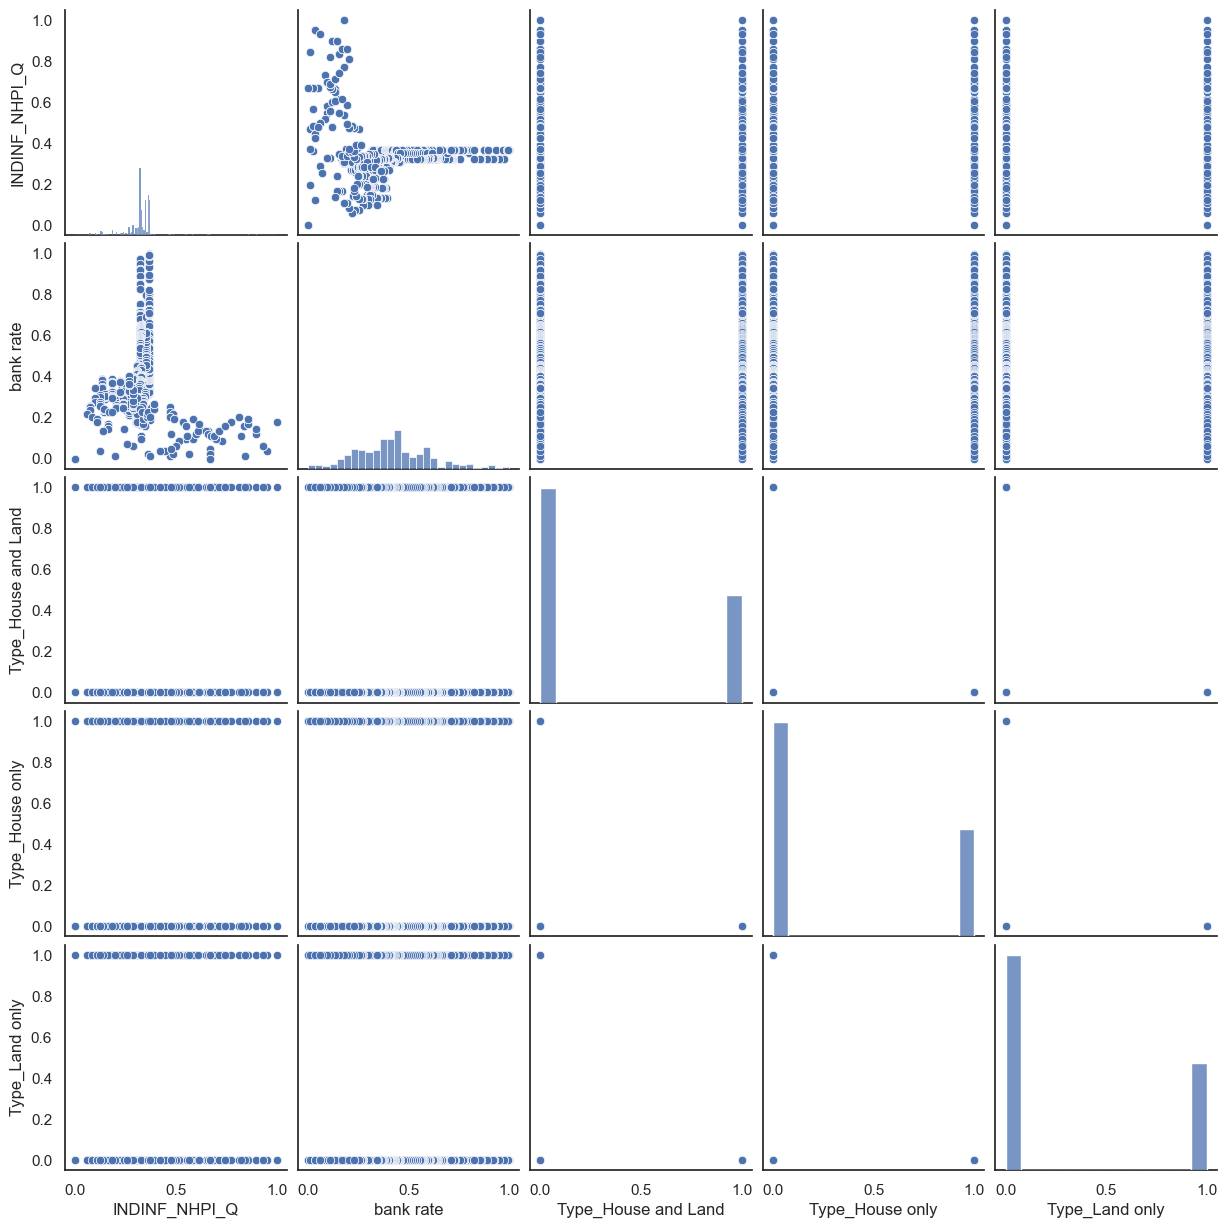

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set(style="white")

# Create a pairplot with a scatter plot for 'INDINF_NHPI_Q' and histograms for other variables
sns.pairplot(result_df, vars=['INDINF_NHPI_Q', 'bank rate', 'Type_House and Land', 'Type_House only', 'Type_Land only'])

# Show the plot
plt.show()


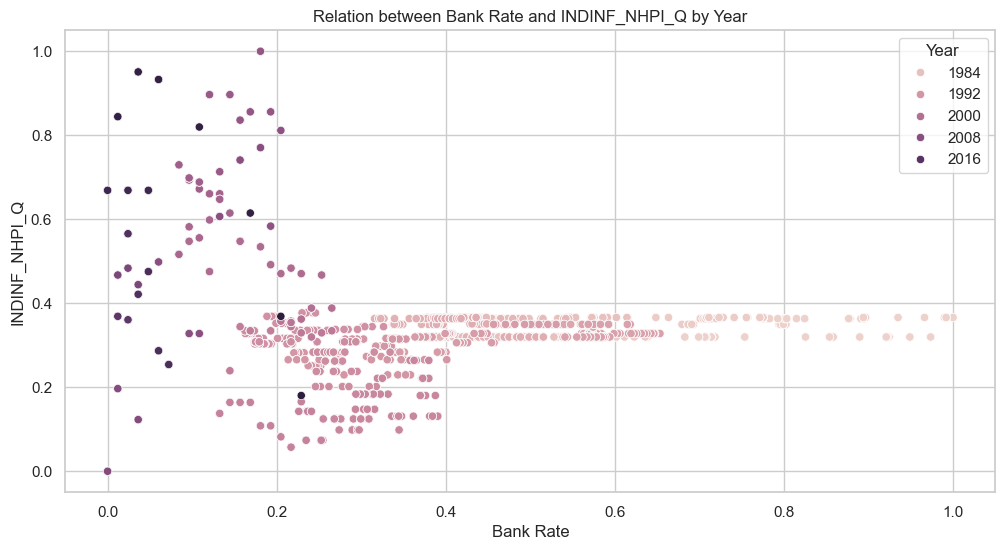

In [250]:
sns.set(style="whitegrid")


plt.figure(figsize=(12, 6))
sns.scatterplot(x='bank rate', y='INDINF_NHPI_Q', hue='year', data=result_df)

# Set plot title and labels
plt.title('Relation between Bank Rate and INDINF_NHPI_Q by Year')
plt.xlabel('Bank Rate')
plt.ylabel('INDINF_NHPI_Q')

# Show the legend
plt.legend(title='Year')

# Show the plot
plt.show()

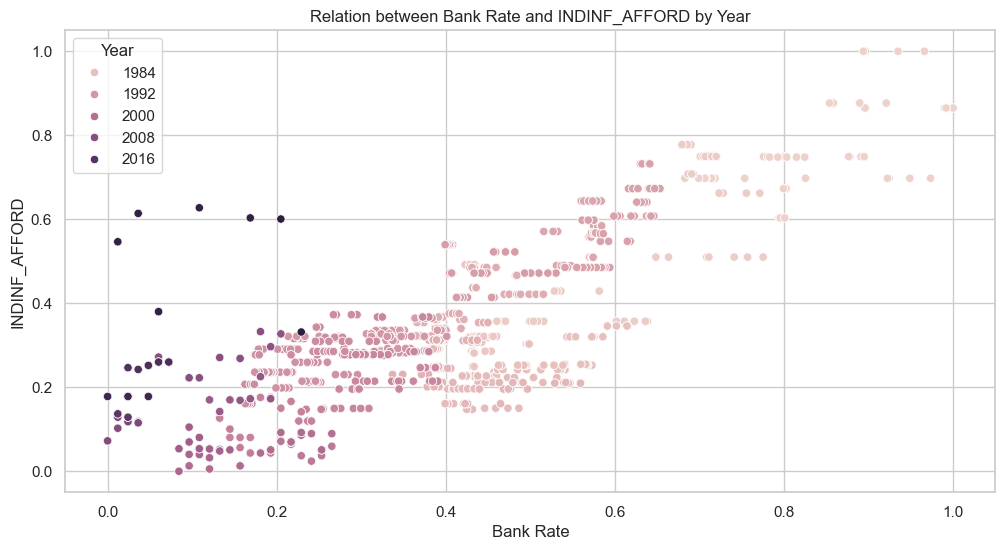

In [251]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bank rate', y='INDINF_AFFORD', hue='year', data=result_df)

# Set plot title and labels
plt.title('Relation between Bank Rate and INDINF_AFFORD by Year')
plt.xlabel('Bank Rate')
plt.ylabel('INDINF_AFFORD')

# Show the legend
plt.legend(title='Year')

# Show the plot
plt.show()

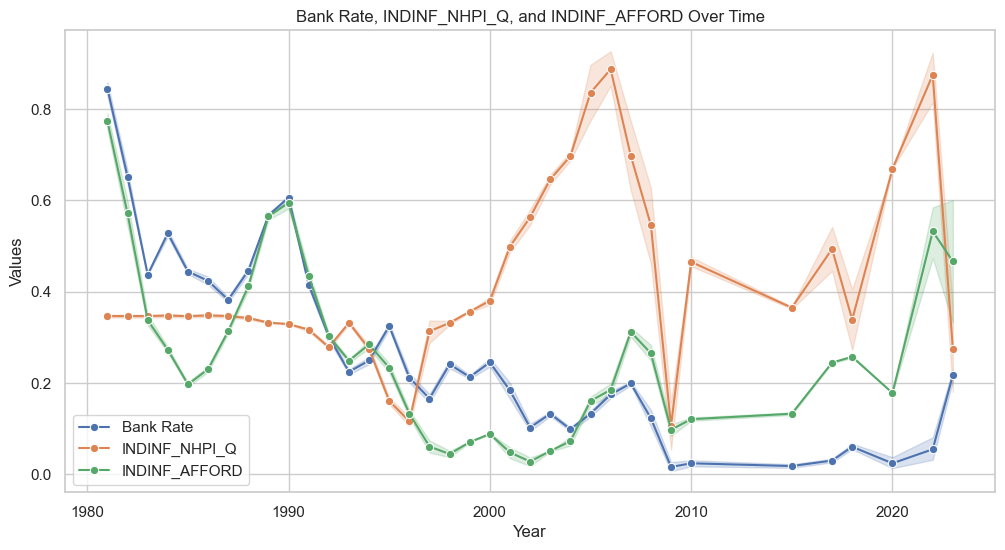

In [252]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='bank rate', data=result_df, label='Bank Rate', marker='o')
sns.lineplot(x='year', y='INDINF_NHPI_Q', data=result_df, label='INDINF_NHPI_Q', marker='o')
sns.lineplot(x='year', y='INDINF_AFFORD', data=result_df, label='INDINF_AFFORD', marker='o')


# Set plot title and labels
plt.title('Bank Rate, INDINF_NHPI_Q, and INDINF_AFFORD Over Time')
plt.xlabel('Year')
plt.ylabel('Values')

# Show the legend
plt.legend()

# Show the plot
plt.show()

Correlation with INDINF_AFFORD:
 INDINF_AFFORD          1.000000
bank rate              0.801344
INDINF_NHPI_Q          0.019732
Type_House and Land   -0.001100
Type_House only       -0.001100
Type_Land only        -0.001100
month                 -0.040035
year                  -0.430428
Name: INDINF_AFFORD, dtype: float64


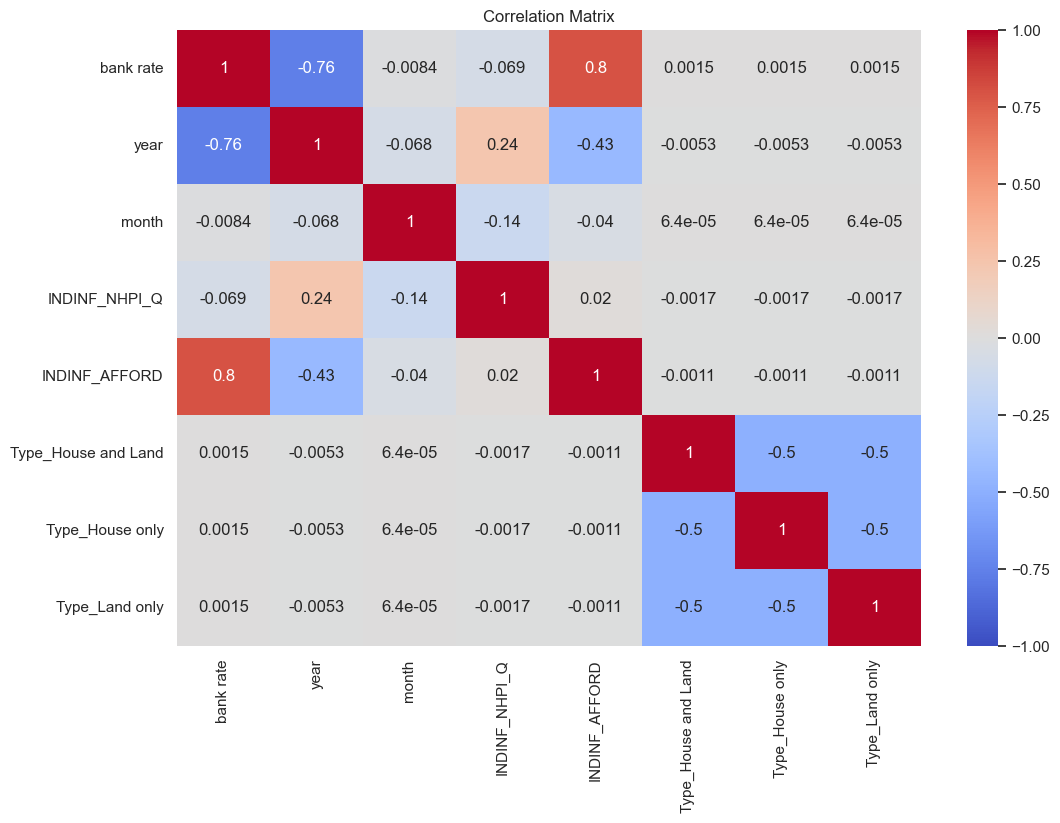

In [253]:
correlation_matrix = result_df.corr()

# Extract the correlation values with the target variable
correlation_with_target = correlation_matrix['INDINF_AFFORD'].sort_values(ascending=False)

# Display the correlation values
print("Correlation with INDINF_AFFORD:\n", correlation_with_target)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()